# 데이터 선언 및 알고리즘 실행 준비
1. 코드 실행에 필요한 라이브러리를 임포트합니다.

In [ ]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2. 가지고 있는 데이터 세트를 변수로 생성하고, 랜덤 시드를 설정합니다.

- `pd.read_csv('Taillard_1.csv', header=None)`: Pandas 라이브러리를 사용하여 `Taillard_1.csv` 파일을 읽어옵니다.

- `header=None`: CSV 파일의 첫 번째 행을 데이터의 열 이름으로 사용하지 않겠다는 것을 의미합니다.

- `data.to_numpy()`: Pandas DataFrame 형식을 Numpy 배열로 변환합니다. 이렇게 하면 배열 연산을 더 효율적으로 수행할 수 있습니다.

In [ ]:
# 데이터 세트 정의
data = pd.read_csv('Taillard_1.csv', header=None)
data = data.to_numpy()
seed = 0
# 랜덤 시드 설정 (재현성을 위해)
np.random.seed(seed)

# 초기 개체군 생성

- `for` 루프를 통해 지정된 개체 수(`num_population`)만큼 반복합니다. 각 반복에서 하나의 개체가 생성됩니다.
- `np.random.choice(num_blocks, num_blocks, replace=False)`: Numpy의 `choice` 함수를 사용하여 `num_blocks` 개의 블록을 무작위로 선택합니다.
- `replace=False`: 동일한 블록이 선택되지 않도록 하여, 블록의 중복 없이 순열을 생성합니다. 이 결과는 `0`부터 `num_blocks-1`까지의 정수로 구성된 배열입니다.
- `population.append(sequence)` : 생성된 순서를 `population` 리스트에 추가합니다.

In [ ]:
# 초기 개체군 생성 함수
def initialize(num_blocks, num_population):
    population = []
    for i in range(num_population):
        sequence = np.random.choice(num_blocks, num_blocks, replace=False)
        population.append(sequence)
    return population

# 적합도(makespan) 계산

`calculate_fitness(blocks, sequence)`는 `blocks` 라는 블록 작업시간 데이터의 배열과, 작업 순서를 의미하는 1차원 배열 `sequence가` 주어졌을 때, 순서대로 블록의 작업 시간을 누적하여 전체 블록이 모두 작업 완료되는 시점인 Makespan을 계산합니다.

1. **함수 정의**:

`calculate_fitness(blocks, sequence)`는 두 개의 매개변수를 받습니다:
`blocks`: 블록의 정보가 담긴 배열입니다.
`sequence`: 블록의 처리 순서를 정의하는 배열입니다.

2. **입력 유형 확인**:

`if isinstance(sequence, list)`: 조건문을 통해 sequence가 리스트인지 확인합니다.
리스트인 경우, `np.array(sequence)` 코드로 리스트를 Numpy 배열로 변환합니다.

3. **블록 및 프로세스 수 정의**:

`num_of_blocks`는 `blocks` 배열의 첫 번째 차원의 크기(블록의 수)를 저장합니다.
`num_of_process`는 두 번째 차원의 크기(프로세스의 수)를 저장합니다.
4. **임시 배열 초기화**:

`temp = np.zeros((num_of_blocks + 1, num_of_process + 1))`를 통해 `temp`라는 2차원 배열을 생성합니다.
이 배열은 블록과 프로세스를 기반으로 한 적합도 계산을 위한 중간 결과를 저장하는 데 사용됩니다.
배열의 크기는 `(num_of_blocks + 1) x (num_of_process + 1)`입니다. 각 차원에 1을 추가하여 경계 조건을 처리할 수 있도록 합니다.

5. **적합도 계산**:

이중 `for` 루프를 사용하여 `i` 번째 블록에 `j `번째 작업이 시행되기 위하여 필요한 가장 빠른 시점을 구하고, 그 값에 블록의 작업 시간을 더합니다.

6. **최종 적합도 저장**:

`C_max = temp[num_of_blocks, num_of_process]`를 통해 모든 블록과 프로세스가 처리된 완료 시간을 구합니다.


In [ ]:
# 적합도 계산 함수
def calculate_fitness(blocks, sequence):
    if isinstance(sequence, list):
        sequence = np.array(sequence)

    num_of_blocks = blocks.shape[0]
    num_of_process = blocks.shape[1]
    temp = np.zeros((num_of_blocks + 1, num_of_process + 1))
    for i in range(1, num_of_blocks + 1):
        for j in range(1, num_of_process + 1):
            if temp[i - 1, j] > temp[i, j - 1]:
                temp[i, j] = temp[i - 1, j] + blocks[sequence[i - 1], j - 1]
            else:
                temp[i, j] = temp[i, j - 1] + blocks[sequence[i - 1], j - 1]
    C_max = temp[num_of_blocks, num_of_process]
    return C_max

7. `selection()` : 주어진 개체군에서 엘리트와 룰렛 선택 방식을 활용해 새로운 부모 집합을 생성하고 반환합니다. 선택 과정은 각 개체의 적합도에 기반해 이루어지며, 최적 개체의 적합도와 염색체 정보도 반환됩니다.

* `population`: 개체군을 나타내는 리스트로, 각 개체는 염색체의 배열로 구성됩니다.

* `_num_elite`: 상위 적합도를 가진 개체 수로, 선택된 엘리트 개체의 개수를 지정합니다.

* `_num_roulette`: 룰렛 선택 방식에서 선택할 개체 수로, 확률에 따라 선택된 개체의 개수를 지정합니다.
*  `_lower_bound` : 알고리즘 실행 시 이미 해당 문제의 최소 makespan 범위에 대한 정보를 알고 있다면, 그 값을 활용하여 확률 계산을 보정하는 데 사용할 수 있습니다.

### 함수의 주요 과정:
- **적합도 계산**:
  - 개체군의 각 개체에 대해 `calculate_fitness`를 호출하여 적합도를 계산하고 `fitness` 리스트에 저장합니다.

- **적합도 기준 정렬**:
  - `np.argsort(fitness)[::-1]`를 통해 적합도 값을 내림차순으로 정렬하고, 상위 엘리트 개체의 인덱스를 반환합니다.
      ```python
  if _lower_bound is not None:
    inverse_fitness = [1/(f - _lower_bound) for f in fitness]
  else:
    inverse_fitness = [1/f for f in fitness]
      ```
  - 위 코드를 활용해 fitness에 따른 확률을 보정할 수 있습니다.
  - 예를 들어, 크기가 `4`인 `population`에서 개체들의 `fitness`가 각각 `[4, 5, 6, 6]`으로 계산되었을 때, 만약 실제 적합도가 최소 3 이상의 값을 갖는다는 사실을 알고 있으면, 적합도를 각각 3을 뺀 `[1, 2, 3, 3]`과 같은 것으로 간주하고 그 역수를 확률 값으로 구할 수 있습니다.
  - 이렇게 하면 적합도가 큰 개체와 작은 개체 사이의 확률 차이를 증가시켜 적합도가 큰 개체가 더욱 자주 나오게 할 수 있습니다.
  
- **엘리트 선택**:
  - 상위 `_num_elite`개의 엘리트를 선택하고, 깊은 복사(`copy.deepcopy`)를 사용하여 `elite` 리스트에 추가합니다.
  - 최상위 개체의 적합도는 `top_fitness`에 저장하여 최적 적합도를 반환합니다.

- **룰렛 선택 확률 계산**:
  - 적합도 값을 역수로 변환하여 `fitness_inverse` 리스트에 저장합니다. 이 값을 `total_inverse_fitness`로 나누어 각 개체의 선택 확률을 계산하고, 확률 리스트 `selection_probs`에 저장합니다.
  
- **최상위 5개 개체 출력**:
  - 상위 5개의 엘리트 개체의 적합도, 염색체 정보, 선택 확률을 출력합니다.

- **룰렛 선택**:
  - `np.random.choice`를 사용하여 `selection_probs`에 따라 `_num_roulette` 개체를 무작위로 선택합니다.
  
- **부모 개체군 생성**:
  - 엘리트 개체와 룰렛 선택된 개체를 결합하여 `parents` 리스트에 저장합니다. `parents`는 반환값으로 최적 개체 정보(`top_fitness`, `top_individual`)와 함께 반환됩니다.
  
이렇게 반환된 부모 개체군은 다음 세대의 개체군을 생성하는 데 사용됩니다.


In [ ]:
# 선택 함수 (selection): 엘리트와 룰렛 선택 방식
def selection(data, population, _num_elite, _num_roulette, _lower_bound = None):
    fitness = []
    for i in range(len(population)):
        fitness.append(calculate_fitness(data, population[i]))

    # Fitness 값을 기준으로 정렬된 index를 얻음 (작을수록 좋은 fit)
    rank = np.argsort(fitness)

    # 상위 엘리트 개체 10개 선택
    elite = [copy.deepcopy(population[i]) for i in rank[:_num_elite]]

    # 적합도 값에 따라 확률을 계산
    if _lower_bound is not None:
        inverse_fitness = [1/(f - _lower_bound) for f in fitness]
    else:
        inverse_fitness = [1/f for f in fitness]

    # Roulette wheel selection을 위해 역수를 합계로 나누어 확률 계산
    selection_probs = [p/sum(inverse_fitness) for p in inverse_fitness]

    # 5개 최상위 적합도를 갖는 5개 개체의 적합도와 염색체 출력
    print("[Top 5 Elites]")
    for i in range(5):
        print(
            f"Elite {i + 1}: Fitness = {round(fitness[rank[i]], 3)}, Chromosome = {[round(ch, 2) for ch in population[rank[i]][:10]]}... , Probability = {round(selection_probs[rank[i]], 5)}")

    # Roulette wheel selection을 통해 추가로 10개 선택
    selected = np.random.choice(len(population), _num_roulette, p=selection_probs, replace=True)

    # Elite 개체와 선택된 개체를 결합하여 새로운 population 구성
    parents = elite + [copy.deepcopy(population[s]) for s in selected]

    return parents, min(fitness), np.copy(population[rank[0]])

# 돌연변이 함수 정의

아래 코드 블록에서는  두 가지 돌연변이 함수, `swap_mutation`과 `swap_neighbor_mutation`을 정의합니다.

## `swap_mutation` 함수

### 설명
- 이 함수는 주어진 염색체에서 두 개의 서로 다른 위치를 선택하여 해당 위치의 값을 교환합니다.
- 이를 통해 염색체의 구조를 변화시켜 새로운 해를 생성합니다.

### 매개변수
- `chromosome`: 변이를 적용할 개체를 입력으로 받습니다. (Numpy 배열)

### 과정
1. **깊은 복사**:
   - `chrom = copy.deepcopy(chromosome)`를 통해 원본 염색체를 복사하여 새로운 염색체 `chrom`을 생성합니다.
   
2. **인덱스 선택**:
   - `index = np.random.choice(len(chromosome), size=2, replace=False)`를 사용하여 서로 다른 두 개의 인덱스를 무작위로 선택합니다.
   
3. **인덱스 정렬**:
   - 선택된 인덱스를 `left`와 `right` 변수에 저장하여 작은 값과 큰 값을 구분합니다.
   
4. **값 교환**:
   - `chrom[left] = chromosome[right]` 및 `chrom[right] = chromosome[left]`를 통해 선택된 두 위치의 값을 교환합니다.
   
5. **결과 반환**:
   - `return chrom.copy()`를 통해 변경된 염색체를 반환합니다.

---

## `swap_neighbor_mutation` 함수

### 설명
- 이 함수는 주어진 염색체에서 인접한 두 개의 원소를 선택하여 교환합니다.

### 매개변수
- `chromosome`: 변이를 적용할 개체를 입력으로 받습니다. (Numpy 배열)

### 과정
1. **깊은 복사**:
   - `chrom = copy.deepcopy(chromosome)`를 사용하여 원본 염색체를 복사하여 새로운 염색체를 생성합니다.
   
2. **인덱스 선택**:
   - `index = np.random.choice(len(chromosome)-1)`를 통해 인접한 두 블록의 위치를 무작위로 선택합니다. 예를 들어, 100개의 블록이 있다면, 0~98 범위에서 하나의 인덱스가 선택됩니다.
   
3. **값 교환**:
   - `chrom[index] = chromosome[index+1]` 및 `chrom[index+1] = chromosome[index]`를 통해 선택된 인접 블록의 값을 교환합니다.
   
4. **결과 반환**:
   - `return chrom.copy()`를 통해 변경된 염색체를 반환합니다.



In [ ]:
def swap_mutation(chromosome):
    chrom = copy.deepcopy(chromosome)
    index = np.random.choice(len(chromosome), size=2, replace=False)  # 서로 다른 두 index 선택
    left = min(index)
    right = max(index)
    chrom[left] = chromosome[right]
    chrom[right] = chromosome[left]
    return chrom.copy()

def swap_neighbor_mutation(chromosome):
    chrom = copy.deepcopy(chromosome)
    index = np.random.choice(len(chromosome)-1)  # 100개의 block이 있다면, 0~98 범위에서 하나의 index 선정
    chrom[index] = chromosome[index+1]
    chrom[index+1] = chromosome[index]
    return chrom.copy()

# PMX Crossover 함수

이 코드 블록은 순열 교차(PMX, Partially Mapped Crossover) 방식으로 두 개체 `p1`과 `p2`를 기반으로 두 개의 자식 개체를 생성하는 `PMXcrossover` 함수를 정의합니다. PMX는 유전 알고리즘에서 개체의 유전자를 교환하여 새로운 해를 만드는 기법입니다.

## `PMXcrossover` 함수

### 설명
- 이 함수는 두 부모 개체의 특정 슬라이스를 선택하고, 선택된 슬라이스를 서로 교환하여 자식 개체를 생성합니다.
- 이를 통해 부모의 특성을 혼합한 새로운 해를 만들어냅니다.

### 매개변수
- `p1`: 첫 번째 부모 개체를 나타내는 배열입니다.
- `p2`: 두 번째 부모 개체를 나타내는 배열입니다.
- `length`: 교환할 슬라이스의 길이를 나타내며, 기본값은 3입니다.

### 과정
1. **자식 초기화**:
   - `child1 = p1.tolist().copy()` 및 `child2 = p2.tolist().copy()`를 통해 부모 개체의 복사본으로 자식 개체를 초기화합니다.

2. **슬라이스 선택**:
   - `indices = np.random.choice(len(p1)-length)`를 사용하여 교환할 슬라이스의 시작 인덱스를 무작위로 선택합니다. (예: 100개의 블록이 있다면, 0~94의 범위에서 추출)
   - `slice_1 = p1[indices:indices+length].tolist().copy()` 및 `slice_2 = p2[indices:indices+length].tolist().copy()`를 통해 선택된 슬라이스를 각각 저장합니다.

3. **슬라이스 통합**:
   - `pool = copy.deepcopy(slice_1)`로 슬라이스 1을 복사하여 풀을 생성합니다.
   - `for s in slice_2:` 루프를 통해 슬라이스 2의 요소를 풀에 추가합니다. 이때 중복된 요소는 제외됩니다.

4. **맵 생성**:
   - `map1`과 `map2` 리스트를 초기화합니다.
   - 첫 번째 자식(`child1`)의 요소 중 풀에 있는 요소들을 `map1`에 추가합니다.
   - 두 번째 자식(`child2`)의 요소 중 풀에 있는 요소들을 `map2`에 추가합니다.

5. **자식 개체의 값 교환**:
   - `for idx, c in enumerate(child1):` 루프를 통해 자식 1에서 풀에 있는 요소들을 `map2`에서의 해당 요소로 교환합니다.
   - `for idx, c in enumerate(child2):` 루프를 통해 자식 2에서 풀에 있는 요소들을 `map1`에서의 해당 요소로 교환합니다.

6. **결과 반환**:
   - `return np.array(child1), np.array(child2)`를 통해 생성된 두 자식 개체를 numpy 배열 형식으로 반환합니다.



In [ ]:
def PMXcrossover(p1, p2, length=3):
    child1 = p1.tolist().copy()
    child2 = p2.tolist().copy()

    indices = np.random.choice(len(p1)-length) # 100개의 블록이 있다면, 0~94의 범위에서 추출
    slice_1 = p1[indices:indices+length].tolist().copy()
    slice_2 = p2[indices:indices+length].tolist().copy()
    pool = copy.deepcopy(slice_1)
    for s in slice_2:
        if s not in pool:
            pool.append(s)
    map1 = list()
    map2 = list()
    for elem in child1:
        if elem in pool:
            map1.append(elem)
    for elem in child2:
        if elem in pool:
            map2.append(elem)
    for idx, c in enumerate(child1):
        if c in pool:
            child1[idx] = map2.pop(0)
    for idx, c in enumerate(child2):
        if c in pool:
            child2[idx] = map1.pop(0)
    return np.array(child1), np.array(child2)

`crossover()` 함수를 활용하여 자식 개체를 만드는 코드의 예시입니다. 결과를 확인해 보세요.

In [ ]:
p1 = np.array([1, 2, 3, 4, 5, 6, 7, 8])
p2 = np.array([8, 7, 6, 5, 4, 3, 2, 1])
child1, child2 = PMXcrossover(p1, p2)
print("Child 1:",child1)
print("Child 2:",child2)

Child 1: [1 7 6 5 4 3 2 8]
Child 2: [8 2 3 4 5 6 7 1]


# 다음 세대(Population) 생성

`reproduction()` : 주어진 부모 개체들을 기반으로 새로운 세대(`new_population`)를 생성합니다. 부모 개체들 중 일부는 엘리트로 유지하며, 나머지 개체들은 교차(crossover)와 돌연변이(mutation) 연산을 통해 생성됩니다.

* `parents`: 부모 개체들을 담은 리스트입니다. 이 부모 개체들을 활용해 새로운 세대를 생성합니다.
* `_num_population`: 생성할 새로운 세대의 개체 수입니다.
* `_num_elite`: 엘리트 개체 수로, 변형 없이 그대로 유지되는 개체 수입니다.
* `_p_crossover`: 교차 연산이 발생할 확률입니다.
* `_p_mutation`: 돌연변이 연산이 발생할 확률입니다.
* `_crossover_length` : PMXcrossover 를 적용할 때 활용할 길이 변수입니다.

### 함수의 주요 과정:
- **엘리트 개체 보존**:
  - `parents[:_num_elite]`를 통해 부모 리스트의 상위 엘리트 개체들을 그대로 복사하여 `new_population`에 추가합니다. 이로써 가장 우수한 개체들은 변형 없이 새로운 세대에 남습니다.

- **교차 및 돌연변이 연산을 통한 개체 생성**:
  - `new_population`의 개체 수가 `_num_population`에 도달할 때까지 반복합니다.
  - `np.random.choice`를 통해 부모 리스트에서 두 개의 개체를 무작위로 선택하여 `p1`과 `p2`로 지정합니다.
  
- **교차 연산**:
  - `np.random.rand() < _p_crossover` 조건을 통해 `_p_crossover` 확률로 `crossover` 함수를 호출하여 `p1`과 `p2`의 유전자를 교환하고, 이를 통해 `child1`과 `child2`를 생성합니다. 교차 연산이 수행되지 않으면 원본 부모 개체가 자식 개체로 추가됩니다.

- **돌연변이 연산**:
  - `np.random.rand() < _p_mutation` 조건에 따라 `_p_mutation` 확률로 각각 `child1`과 `child2`에 대해 `mutation` 함수를 호출하여 유전자를 변형시킵니다.

- **새로운 세대 구성**:
  - 생성된 자식 개체들을 `new_population`에 추가합니다. 만약 `new_population`의 개체 수가 `_num_population`을 초과할 경우, 초과된 개체는 제외하고 반환합니다.

이 함수는 유전 알고리즘의 세대 교체 과정에서 엘리트 보존, 교차, 돌연변이 연산을 통해 개체 다양성을 유지하고, 새로운 세대를 생성하도록 설계되었습니다.


In [ ]:
def reproduction(parents, _num_population, _num_elite, _p_crossover=0.9, _p_mutation=0.1, _crossover_length = 3):
    new_population = list()  # 초기 부모 리스트에 Elite 10과 선택된 10 포함

    # Elite 개체는 new_population에 그대로 남김
    elite = copy.deepcopy(parents[:_num_elite])
    new_population.extend(elite)

    while len(new_population) < _num_population:
        # 부모 중에서 두 개체 무작위 선택
        parents_indices = np.random.choice(len(parents), 2, replace=False)
        p1 = copy.deepcopy(parents[parents_indices[0]])
        p2 = copy.deepcopy(parents[parents_indices[1]])

        # Crossover 수행 여부
        if np.random.rand() < _p_crossover:
            child1, child2 = PMXcrossover(p1, p2, length=_crossover_length)
        else:
            child1, child2 = p1, p2  # crossover가 없으면 원본 유지

        # Mutation 수행 여부
        # if np.random.rand() < _p_mutation:
        #     child1 = swap_mutation(child1)
        # if np.random.rand() < _p_mutation:
        #     child2 = swap_mutation(child2)
        if np.random.rand() < _p_mutation:
            child1 = swap_neighbor_mutation(child1)
        if np.random.rand() < _p_mutation:
            child2 = swap_neighbor_mutation(child2)

        # New population에 추가
        new_population.extend([child1, child2])

    # 만약 population 크기가 초과한 경우 자르기
    return new_population[:_num_population]

# 유전 알고리즘 실행

`run_GA()` : 유전 알고리즘(Genetic Algorithm, GA)을 실행하여 목표 조건을 만족하는 최적의 개체를 찾아내는 함수입니다.

* `_num_population`: 초기 개체군의 크기입니다.
* `_num_elite`: 세대마다 유지되는 엘리트 개체 수입니다.
* `_num_generation`: 유전 알고리즘을 반복 실행할 총 세대 수를 의미합니다.
* `_p_crossover`: 교차 연산이 발생할 확률입니다.
* `_p_mutation`: 돌연변이 연산이 발생할 확률입니다.

### 함수의 주요 과정:
- **초기 설정 및 개체군 초기화**:
  - `initialize` 함수를 호출하여 `_num_population` 크기의 초기 개체군을 생성합니다.
  - `top_fitness`는 최고 적합도를 추적하며 초기화됩니다.
  - `top_fitness_record` 리스트는 각 세대의 최고 적합도를 저장합니다.
  - `top_individual`은 최고 적합도를 지닌 개체를 저장합니다.

- **세대 반복 실행**:
  - `while generations < _num_generation: ` 조건을 통해 목표 세대 수에 도달할 때까지 반복합니다.
  - **세대 표시**: 세대 수를 증가시키고, `print('-' * 15 + ' Generation ' + str(generations) + ' ' + '-' * 15)` 코드를 통해 세대 구분을 콘솔에 표시합니다.
  - **선택 및 재생산**:
    - `selection` 함수를 통해 엘리트 개체와 룰렛 선택을 사용해 부모를 선택합니다. 각 세대에서 최상위 적합도와 그에 해당하는 개체(`top_individual`)가 갱신됩니다.
    - `reproduction` 함수를 호출해 교차와 돌연변이 연산을 통해 새로운 세대를 생성합니다.
  - **적합도 기록**: `top_fitness_record`에 현재 세대의 최고 적합도를 추가하고, 최상위 개체와 해당 적합도를 출력합니다.

- **결과 반환**:
  - 최종적으로 세대가 종료된 후 최종 개체군(`population`), 최고 적합도의 개체(`top_individual`), 각 세대의 최고 적합도를 담은 `top_fitness_record`를 반환합니다.



In [ ]:

# 유전 알고리즘 실행 함수
def run_GA(_num_blocks, _num_population=10, _num_elite=20, _num_generation=1000, _p_crossover=0.9, _p_mutation=0.7):
    _num_roulette = _num_population - _num_elite
    generations = 0

    population = initialize(_num_blocks, _num_population) # 초기 개체군 생성
    top_fitness = 0.0
    top_fitness_record = []
    top_individual = None

    while generations < _num_generation:
    # while top_fitness <= -1.0:
        generations += 1
        print('-' * 15 + ' Generation ' + str(generations) + ' ' + '-' * 15)
        parents, top_fitness, top_individual = selection(data, population,
                                                         _num_elite=_num_elite,
                                                         _num_roulette=_num_roulette,
                                                         _lower_bound = 5493)
        population = reproduction(parents, _num_population, _num_elite=2,
                                  _p_crossover=0.7, _p_mutation=0.9, _crossover_length = 3)
        top_fitness_record.append(top_fitness)
        print('Top Individual:', [round(t, 2) for t in top_individual[:10]],"...", round(top_fitness,3))

    return population, np.copy(top_individual), top_fitness_record

`run_GA()` 함수를 실행하여 유전알고리즘을 실행해 봅시다.

In [ ]:
# 알고리즘 실행
population, top_individual, top_fitness_record = run_GA(_num_blocks=100,
                                                        _num_population=100,
                                                        _num_elite=20,
                                                        _num_generation=500,
                                                        _p_crossover=1.0,
                                                        _p_mutation=1.0)

--------------- Generation 1 ---------------
[Top 5 Elites]
Elite 1: Fitness = 5831.0, Chromosome = [77, 4, 70, 38, 33, 91, 60, 11, 73, 27]... , Probability = 0.01791
Elite 2: Fitness = 5846.0, Chromosome = [66, 1, 26, 57, 89, 8, 39, 16, 0, 99]... , Probability = 0.01715
Elite 3: Fitness = 5859.0, Chromosome = [69, 62, 84, 98, 19, 1, 12, 25, 59, 58]... , Probability = 0.01654
Elite 4: Fitness = 5860.0, Chromosome = [38, 75, 10, 70, 3, 20, 30, 17, 27, 55]... , Probability = 0.01649
Elite 5: Fitness = 5867.0, Chromosome = [30, 43, 68, 44, 59, 4, 41, 15, 87, 2]... , Probability = 0.01619
Top Individual: [77, 4, 70, 38, 33, 91, 60, 11, 73, 27] ... 5831.0
--------------- Generation 2 ---------------
[Top 5 Elites]
Elite 1: Fitness = 5812.0, Chromosome = [69, 62, 84, 98, 19, 1, 12, 25, 59, 58]... , Probability = 0.01589
Elite 2: Fitness = 5824.0, Chromosome = [30, 43, 68, 44, 59, 4, 41, 15, 87, 2]... , Probability = 0.01531
Elite 3: Fitness = 5827.0, Chromosome = [71, 14, 89, 28, 56, 63, 12,

# 결과 확인
결과는 jupyter notebook 셀에 `top_individual` 변수를 입력하여 확인할 수 있습니다.

In [ ]:
top_individual

array([14, 77, 43, 49, 40, 94,  1, 95, 26, 57, 25, 24,  4, 78, 98, 79, 99,
        3, 71, 97, 60, 18, 90, 89, 31, 41, 86, 65, 63, 27, 37, 70,  8, 83,
       23, 13, 91,  0, 59, 42, 33, 84, 10, 52, 72, 39, 66, 96, 69, 20, 11,
       68, 38, 54, 85, 34, 44, 32, 93, 62, 82, 28, 80, 56, 53, 46, 67, 92,
       73, 48, 29, 64, 12, 50, 75, 17, 88, 51, 81, 30, 61,  7,  9,  6, 87,
       35, 45,  5, 19, 74, 76, 16,  2, 21, 55, 36, 15, 47, 58, 22])

다음 코드를 실행하여 전체 population의 개체 분포를 확인해 보세요.

In [ ]:
# 결과 표시
print("-"*15,"Result","-"*15)
for idx, p in enumerate(population):
    f = calculate_fitness(data, p)
    print(
        f"Individual {idx+1}: Fitness = {round(f, 3)}, Chromosome = {[round(ch, 2) for ch in p][:10]}...")

--------------- Result ---------------
Individual 1: Fitness = 5558.0, Chromosome = [14, 77, 43, 49, 40, 94, 1, 95, 26, 57]...
Individual 2: Fitness = 5558.0, Chromosome = [14, 77, 43, 49, 40, 94, 1, 95, 26, 57]...
Individual 3: Fitness = 5558.0, Chromosome = [14, 77, 43, 49, 40, 94, 1, 95, 26, 57]...
Individual 4: Fitness = 5559.0, Chromosome = [14, 77, 43, 49, 40, 94, 95, 1, 26, 57]...
Individual 5: Fitness = 5558.0, Chromosome = [14, 77, 43, 49, 40, 94, 1, 95, 26, 57]...
Individual 6: Fitness = 5558.0, Chromosome = [14, 77, 43, 49, 40, 94, 1, 95, 26, 57]...
Individual 7: Fitness = 5558.0, Chromosome = [14, 77, 43, 49, 40, 94, 1, 95, 26, 57]...
Individual 8: Fitness = 5564.0, Chromosome = [14, 77, 43, 49, 40, 95, 94, 1, 26, 57]...
Individual 9: Fitness = 5558.0, Chromosome = [14, 77, 43, 49, 40, 94, 95, 1, 26, 57]...
Individual 10: Fitness = 5591.0, Chromosome = [14, 77, 43, 49, 40, 94, 95, 1, 26, 57]...
Individual 11: Fitness = 5559.0, Chromosome = [14, 77, 43, 49, 40, 94, 1, 95, 26

# 후처리
유전 알고리즘으로 구한 결과를 시각화해 봅시다.

### 후처리 코드 설명
- `plt.figure()`: 새로운 그래프를 그리기 위해 이미지 객체를 생성합니다.
  
- `plt.plot(top_fitness_record, c='black', label='Fitness')`:
  - `top_fitness_record`를 y축으로 하여 선 그래프를 그립니다.
  - `c='black'`: 선의 색상을 검정으로 설정합니다.
  - `label='Fitness'`: 이 선에 대한 범례(label)를 'Fitness'로 설정합니다.

- `plt.title('Fitness(seed={0})'.format(seed))`: 그래프의 제목을 설정합니다. 여기서 `seed`는 랜덤 시드 값으로, 결과의 재현성을 강조합니다.

- `plt.xlabel('Generation')`: x축의 레이블을 'Generation'으로 설정하여 세대 수를 나타냅니다.

- `plt.ylabel('Makespan')`: y축의 레이블을 'Makespan'으로 설정하여 결과의 적합도 측정 기준을 나타냅니다.

- `plt.show()`: 생성된 그래프를 화면에 출력합니다.


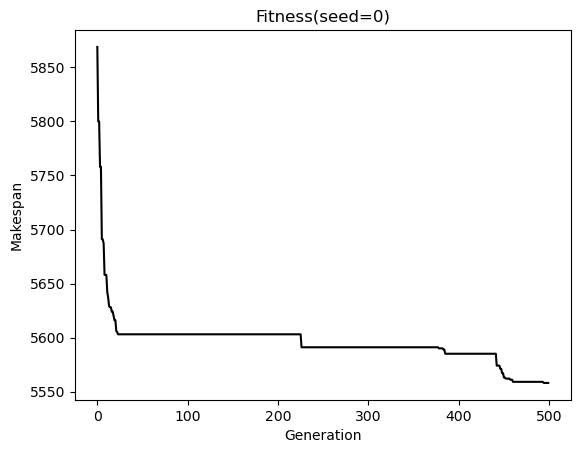

In [ ]:
# 결과 그래프 생성
plt.figure()
plt.plot(top_fitness_record, c='black', label='Fitness')
plt.title('Fitness(seed={0})'.format(seed))
plt.xlabel('Generation')
plt.ylabel('Makespan')
plt.show()